## **Implementation**

In [1]:
%load_ext Cython

In [68]:
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

import pickle
import numpy as np

## $\sum_{i=1}^{N}(y_i - \frac{ \sum_{i=1}^{N} y_i }{N})^2 = \sum_{i=1}^{N-1} y_i^2 + y^2_N - \frac {(\sum_{i=1}^{N-1} y_i + y_N)^2}{N}$

In [54]:
%%cython -a 

import numpy as np
cimport numpy as np
from sklearn.utils import shuffle

cdef class CART:
    cdef public int max_depth
    cdef public int min_leaf_size
    cdef public int step
    cdef public int feature_idx
    
    cdef public np.float64_t threshold
    cdef public np.float64_t value
    
    cpdef CART left
    cpdef CART right
    
    def __init__(self, int max_depth=3, int min_leaf_size=3, int step=1):
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.step = step
        
        self.left = None
        self.right = None
        self.threshold = -1
        self.feature_idx = -1
        self.value = 0
        
    def get_right(self):
        return self.right
    
    def get_left(self):
        return self.left

    def __set_leaf_value(self, np.ndarray[np.float64_t, ndim=1] y):
        return y.sum() / np.abs(y).sum()
        
    def fit(self, np.ndarray[np.float64_t, ndim=2] X, np.ndarray[np.float64_t, ndim=1] y):
        idxs = np.argsort(X, axis=0)
        mask = np.array([True]*X.shape[0])
        y_square = y**2
        self.__fit(X, y, y_square, idxs, mask)
        
    def __fit(self, np.ndarray[np.float64_t, ndim=2] X,
              np.ndarray[np.float64_t, ndim=1] y,
              np.ndarray[np.float64_t, ndim=1] y_square,
              np.ndarray[long, ndim=2] idxs,
              np.ndarray[np.uint8_t, ndim=1, cast=True] mask):
        
        if self.max_depth <= 0:
            self.value = self.__set_leaf_value(y[mask])
            return
        
        cpdef long i = 0
        cpdef long idx = 0
        cpdef long idx_next = 0
        cpdef np.float64_t error = ((y[mask] - y[mask].mean()) ** 2).sum()
        cpdef np.ndarray[np.float64_t, ndim=1] summ
        
        cpdef np.ndarray[long, ndim=2] idxs_mask = np.zeros((X[mask].shape[0], X.shape[1]), dtype=int)
        for feat in range(X.shape[1]):
            idxs_mask[:, feat] = idxs[:, feat][mask[idxs[:, feat]]]

        cpdef np.ndarray[np.float64_t, ndim=1] error_left = np.repeat(((y[mask] - y[mask].mean())**2).sum(), X.shape[1])
        cpdef np.ndarray[np.float64_t, ndim=1] error_right = np.zeros(X.shape[1])
        cpdef np.ndarray[np.float64_t, ndim=1] sum_left = np.repeat(y[mask].sum(), X.shape[1])
        cpdef np.ndarray[np.float64_t, ndim=1] sum_right = np.zeros(X.shape[1])
        cpdef np.ndarray[np.float64_t, ndim=1] sum_square_left = np.repeat(y_square[mask].sum(), X.shape[1])
        cpdef np.ndarray[np.float64_t, ndim=1] sum_square_right = np.zeros(X.shape[1])
        cpdef long n_left = X[mask].shape[0]
        cpdef long n_right = 0
        
        flag = False
        while i < X[mask].shape[0]-1:
            sum_left = sum_left - y[idxs_mask[i]]
            sum_right = sum_right + y[idxs_mask[i]]
            sum_square_left = sum_square_left - y_square[idxs_mask[i]]
            sum_square_right = sum_square_right + y_square[idxs_mask[i]]
            
            i = i + 1
            if i % self.step != 0:
                continue
            
            n_left = n_left - self.step
            n_right = n_right + self.step
            
            if int(n_right/self.step) < self.min_leaf_size:
                continue
            elif int(n_left/self.step) < self.min_leaf_size:
                break
            
            if n_left != 1:
                error_left = sum_square_left - ((sum_left)**2 / n_left)
            else:
                error_left = np.zeros(X.shape[1])
            error_right = sum_square_right - ((sum_right)**2 / n_right)
            
            if min(int(n_left/self.step), int(n_right/self.step)) > self.min_leaf_size:
                summ = error_left + error_right
                if len(summ[X[idxs_mask[i-1], np.arange(X.shape[1])]!=X[idxs_mask[i], np.arange(X.shape[1])]]) > 0:
                    if error > np.min(summ[X[idxs_mask[i-1], np.arange(X.shape[1])]!=X[idxs_mask[i], np.arange(X.shape[1])]]):
                        error = np.min((error_left + error_right)[X[idxs_mask[i-1], np.arange(X.shape[1])]!=X[idxs_mask[i], np.arange(X.shape[1])]])

                        summ[X[idxs_mask[i-1], np.arange(X.shape[1])]==X[idxs_mask[i], np.arange(X.shape[1])]] = (summ.sum())**2
                        self.feature_idx = np.argmin(summ)

                        self.threshold = (X[idxs_mask[i-1], np.arange(X.shape[1])][self.feature_idx] + X[idxs_mask[i], np.arange(X.shape[1])][self.feature_idx]) / 2

        if self.threshold == -1:
            self.value = self.__set_leaf_value(y[mask])
            return
        
        self.left = CART(self.max_depth-1, self.min_leaf_size)
        self.right = CART(self.max_depth-1, self.min_leaf_size)
        
        self.left.__fit(X, y, y_square, idxs, ((X[:, self.feature_idx] > self.threshold) & mask))
        self.right.__fit(X, y, y_square, idxs, ((X[:, self.feature_idx] <= self.threshold) & mask))
            
    def __predict(self, np.ndarray[np.float64_t, ndim=1] x):
        if self.threshold == -1:
            return self.value
        
        if x[self.feature_idx] > self.threshold:
            return self.left.__predict(x)
        else:
            return self.right.__predict(x)
    
    def predict(self, np.ndarray[np.float64_t, ndim=2] X):
        y = []
        for x in X:
            y.append(self.__predict(x))
        return np.array(y)





cdef class AdaGradBoostClassifier:
    cdef public int n_trees
    cdef public int max_depth
    cdef public int min_leaf_size
    cdef public int step
    cdef public np.float64_t subsample
    cdef public np.float64_t init_model
    cdef public list trees
    cdef public list shrinkage
    cdef public list train_loss
    cdef public list test_loss

    def __init__(self, int n_trees=100,
                  int step=1,
                  int max_depth=3,
                  int min_leaf_size=5,
                  np.float64_t subsample=-1):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.subsample = subsample
        self.step = step
        self.init_model = 0
        self.trees = []
        self.shrinkage = []
        self.train_loss = []
        self.test_loss = []

    def __ada_loss(self, f_y, y):
        return np.exp((-1)*f_y*y)

    def __ada_loss_mean(self, f_y, y):
        return np.exp((-1)*f_y*y).mean()
    
    def __grad_ada_loss(self, f_y, y):
        return (-1)*y*np.exp((-1)*f_y*y)

    def __start_model(self, y):
        return 0
    
    def fit(self,  np.ndarray[np.float64_t, ndim=2] X, 
              np.ndarray[np.float64_t, ndim=1] y, 
              np.ndarray[np.float64_t, ndim=2] X_valid=None, 
              np.ndarray[np.float64_t, ndim=1] y_valid=None, 
              np.float64_t lr=0.1):
        
        cpdef CART tree
        cdef np.ndarray[long, ndim=1] indx
        self.train_loss = []
        self.test_loss = []

        y_out = np.repeat(self.__start_model(y), y.shape[0])
        if type(y_valid)!=None and type(X_valid)!=None:
            y_valid_out = np.repeat(self.__start_model(y_valid), y_valid.shape[0])

        if type(X_valid)==None or type(y_valid)==None:
            tmp_loss = self.__ada_loss_mean(y_out, y)
            print("Start loss: " + str(tmp_loss))
            self.train_loss.append(tmp_loss)
        else:
            tmp_train_loss = self.__ada_loss_mean(y_out, y)
            tmp_test_loss = self.__ada_loss_mean(y_valid_out, y_valid)
            print("Train | Start loss:", str(tmp_train_loss), ":: Test | Start loss:", str(tmp_test_loss))
            self.train_loss.append(tmp_train_loss)
            self.test_loss.append(tmp_test_loss)
        
        for i in range(self.n_trees):
            if 0 < self.subsample <= 1:
                indx = shuffle(np.arange(len(y)))[: int(len(y)*self.subsample)]
            
            tree = CART(max_depth=self.max_depth, min_leaf_size=self.min_leaf_size, step=self.step)
            if 0 < self.subsample <= 1:
                tree.fit(X[indx], self.__grad_ada_loss(y_out[indx], y[indx]))
            else:
                tree.fit(X, self.__grad_ada_loss(y_out, y))
            self.trees.append(tree)
            self.shrinkage.append(lr)

            y_out = y_out - lr * tree.predict(X)
            if type(y_valid)!=None and type(X_valid)!=None:
                y_valid_out = y_valid_out - lr * tree.predict(X_valid)
            
            if type(X_valid)==None or type(y_valid)==None:
                if np.abs(self.__ada_loss_mean(y_out, y) - tmp_loss) < 0.0001:
                    lr = lr / 1.5
                tmp_loss = self.__ada_loss_mean(y_out, y)
                print("Train | Tree", str(i+1) + ":", str(round(tmp_loss, 5)))
            else:
                if np.abs(self.__ada_loss_mean(y_out, y) - tmp_train_loss) < 0.0001:
                    lr = lr / 1.5
                tmp_train_loss = self.__ada_loss_mean(y_out, y)
                tmp_test_loss = self.__ada_loss_mean(y_valid_out, y_valid)
                print("Train | Tree", str(i+1) + ":", str(round(tmp_train_loss, 5)), ":: Test | Tree", str(i+1) + ":", str(round(tmp_test_loss, 5)))
                self.train_loss.append(tmp_train_loss)
                self.test_loss.append(tmp_test_loss)
                
    def predict(self, np.ndarray[np.float64_t, ndim=2] X):
        cdef np.ndarray[np.float64_t, ndim=1] y_out

        y_out = np.repeat(self.init_model, X.shape[0])
        for tree, lr in zip(self.trees, self.shrinkage):
            y_out = y_out - lr * tree.predict(X)
        return y_out

## Data

In [8]:
import pandas as pd
train = pd.read_csv('spam.train.txt', sep=' ', header=None)
test = pd.read_csv('spam.test.txt', sep=' ', header=None)

y_train = (train.values)[:, 0]
X_train = (train.values)[:, 1:]
y_train[y_train==0] = -1

y_test = (test.values)[:, 0]
X_test = (test.values)[:, 1:]
y_test[y_test==0] = -1

train = None
test = None

In [57]:
%%time
model = AdaGradBoostClassifier(n_trees=150, step=1, min_leaf_size=5, max_depth=3, subsample=0.9)
model.fit(X_train, y_train, X_valid=X_test, y_valid=y_test, lr=0.15)

Train | Start loss: 1.0 :: Test | Start loss: 1.0
Train | Tree 1: 0.91313 :: Test | Tree 1: 0.93552
Train | Tree 2: 0.83939 :: Test | Tree 2: 0.88631
Train | Tree 3: 0.77751 :: Test | Tree 3: 0.83649
Train | Tree 4: 0.71924 :: Test | Tree 4: 0.80537
Train | Tree 5: 0.67039 :: Test | Tree 5: 0.79594
Train | Tree 6: 0.62543 :: Test | Tree 6: 0.75506
Train | Tree 7: 0.58371 :: Test | Tree 7: 0.69249
Train | Tree 8: 0.54945 :: Test | Tree 8: 0.65938
Train | Tree 9: 0.51851 :: Test | Tree 9: 0.62879
Train | Tree 10: 0.49274 :: Test | Tree 10: 0.61463
Train | Tree 11: 0.46774 :: Test | Tree 11: 0.59025
Train | Tree 12: 0.44398 :: Test | Tree 12: 0.55992
Train | Tree 13: 0.42477 :: Test | Tree 13: 0.53946
Train | Tree 14: 0.40569 :: Test | Tree 14: 0.52078
Train | Tree 15: 0.3866 :: Test | Tree 15: 0.50108
Train | Tree 16: 0.37032 :: Test | Tree 16: 0.47766
Train | Tree 17: 0.35653 :: Test | Tree 17: 0.46769
Train | Tree 18: 0.34145 :: Test | Tree 18: 0.45113
Train | Tree 19: 0.32845 :: Test 

In [59]:
with open('adagrad_train.pickle', 'wb') as f:
    pickle.dump(model.train_loss, f)

with open('adagrad_test.pickle', 'wb') as f:
    pickle.dump(model.test_loss, f)

In [60]:
#with open('adagrad_test.pickle', 'rb') as f:
#    test_loss = pickle.load(f)

In [17]:
%%time
model = AdaGradBoostClassifier(n_trees=150, step=1, min_leaf_size=5, max_depth=3)
model.fit(X_train, y_train, X_valid=X_test, y_valid=y_test)

Train | Start loss: 1.0 :: Test | Start loss: 1.0
Train | Tree 1: 0.94071 :: Test | Tree 1: 0.95168
Train | Tree 2: 0.8884 :: Test | Tree 2: 0.90152
Train | Tree 3: 0.84072 :: Test | Tree 3: 0.86992
Train | Tree 4: 0.79796 :: Test | Tree 4: 0.83913
Train | Tree 5: 0.75882 :: Test | Tree 5: 0.80437
Train | Tree 6: 0.7208 :: Test | Tree 6: 0.79534
Train | Tree 7: 0.6871 :: Test | Tree 7: 0.77569
Train | Tree 8: 0.65439 :: Test | Tree 8: 0.74893
Train | Tree 9: 0.62542 :: Test | Tree 9: 0.71691
Train | Tree 10: 0.59891 :: Test | Tree 10: 0.70846
Train | Tree 11: 0.57187 :: Test | Tree 11: 0.67502
Train | Tree 12: 0.55081 :: Test | Tree 12: 0.66837
Train | Tree 13: 0.52934 :: Test | Tree 13: 0.64598
Train | Tree 14: 0.50908 :: Test | Tree 14: 0.62277
Train | Tree 15: 0.48967 :: Test | Tree 15: 0.61899
Train | Tree 16: 0.47067 :: Test | Tree 16: 0.58769
Train | Tree 17: 0.45477 :: Test | Tree 17: 0.57406
Train | Tree 18: 0.43945 :: Test | Tree 18: 0.54949
Train | Tree 19: 0.42605 :: Test | 

In [13]:
sklearn_model = GradientBoostingClassifier(n_estimators=150, loss='exponential', criterion='mse', learning_rate=0.1,
                                min_samples_split=10, max_depth=3, init='zero', verbose=2)

In [14]:
sklearn_model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.9407            7.93s
         2           0.8876            7.72s
         3           0.8406            7.58s
         4           0.7982            7.57s
         5           0.7568            7.60s
         6           0.7215            7.48s
         7           0.6875            7.47s
         8           0.6576            7.44s
         9           0.6294            7.42s
        10           0.6019            7.37s
        11           0.5746            7.34s
        12           0.5510            7.32s
        13           0.5298            7.30s
        14           0.5088            7.26s
        15           0.4898            7.24s
        16           0.4718            7.22s
        17           0.4572            7.19s
        18           0.4410            7.13s
        19           0.4267            7.07s
        20           0.4130            7.03s
        21           0.4000            7.13s
        2

GradientBoostingClassifier(criterion='mse', init='zero', learning_rate=0.1,
              loss='exponential', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=10, min_weight_fraction_leaf=0.0,
              n_estimators=150, presort='auto', random_state=None,
              subsample=1.0, verbose=2, warm_start=False)

In [71]:
sklearn_model = GradientBoostingClassifier(n_estimators=150, loss='exponential', criterion='mse', learning_rate=0.15,
                                min_samples_split=10, max_depth=3, init='zero', verbose=2)

In [72]:
sklearn_model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.9133            9.23s
         2           0.8398            8.45s
         3           0.7783            8.10s
         4           0.7203            8.07s
         5           0.6726            8.01s
         6           0.6278            7.91s
         7           0.5850            7.83s
         8           0.5509            7.79s
         9           0.5180            7.76s
        10           0.4889            7.68s
        11           0.4620            7.63s
        12           0.4402            7.62s
        13           0.4185            7.68s
        14           0.3989            7.73s
        15           0.3820            7.71s
        16           0.3677            7.71s
        17           0.3533            7.62s
        18           0.3391            7.55s
        19           0.3258            7.52s
        20           0.3138            7.59s
        21           0.3014            7.61s
        2

GradientBoostingClassifier(criterion='mse', init='zero', learning_rate=0.15,
              loss='exponential', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=10, min_weight_fraction_leaf=0.0,
              n_estimators=150, presort='auto', random_state=None,
              subsample=1.0, verbose=2, warm_start=False)

In [73]:
test_score = []
for i in sklearn_model.staged_decision_function(X_test):
    test_score.append(np.exp((-1) * i.reshape(1, -1) * y_test).mean())
test_score = np.array(test_score)

In [74]:
test_score

array([0.93656295, 0.89017172, 0.83174214, 0.80034723, 0.74751856,
       0.73963682, 0.69066226, 0.66138055, 0.63278829, 0.6067684 ,
       0.56337475, 0.55083436, 0.53341679, 0.50546439, 0.48620368,
       0.47245168, 0.4611107 , 0.44908287, 0.4344583 , 0.41695428,
       0.40688668, 0.41665363, 0.40912768, 0.40568025, 0.39858362,
       0.3877747 , 0.38022269, 0.37128644, 0.36890052, 0.36426368,
       0.35879669, 0.3522982 , 0.34940206, 0.34681871, 0.35004756,
       0.3479344 , 0.34367541, 0.34028516, 0.3359926 , 0.33933472,
       0.3383806 , 0.33180142, 0.33003778, 0.32411391, 0.32642056,
       0.32200525, 0.31847018, 0.31801996, 0.3144821 , 0.31448344,
       0.31323485, 0.30787342, 0.30570064, 0.30377947, 0.3018199 ,
       0.29943436, 0.30145024, 0.29962951, 0.29727831, 0.29743785,
       0.29614118, 0.29443116, 0.29253071, 0.29402036, 0.2912029 ,
       0.29426552, 0.29353607, 0.29218299, 0.29126648, 0.29021532,
       0.29038296, 0.28944429, 0.2880249 , 0.28537362, 0.28397

## Train loss

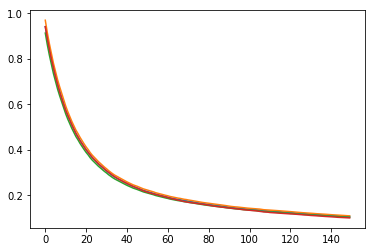

In [102]:
n = 0
m = 151
plt.plot(sklearn_model.train_score_[n:m])
plt.plot(sklearn_model.train_score_[n:m] * 1.03)
plt.plot(sklearn_model.train_score_[n:m] * 0.97)
plt.plot(model.train_loss[n+1:m+1]) # плюс один потому что у меня учитывается лосс начальной инициализации
                                  # а в sklearn сразу с первого дерева

## Test loss

In [15]:
test_score = []
for i in sklearn_model.staged_decision_function(X_test):
    test_score.append(np.exp((-1) * i.reshape(1, -1) * y_test).mean())
test_score = np.array(test_score)

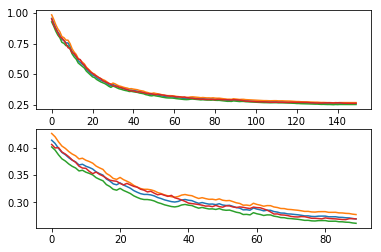

In [23]:
n = 0
m = 151

plt.subplot(2, 1, 1)
plt.plot(test_score[n:m])
plt.plot(test_score[n:m] * 1.03)
plt.plot(test_score[n:m] * 0.97)
plt.plot(model.test_loss[n+1:m+1])

n = 20
m = 100
plt.subplot(2, 1, 2)
plt.plot(test_score[n:m])
plt.plot(test_score[n:m] * 1.03)
plt.plot(test_score[n:m] * 0.97)
plt.plot(model.test_loss[n+1:m+1]) # плюс один потому что у меня учитывается лосс начальной инициализации
                                   # а в sklearn сразу с первого дерева

## XGBoost

In [2]:
%%cython -a 

import numpy as np
cimport numpy as np
from sklearn.utils import shuffle

cdef class xgboost_CART:
    cdef public int max_depth
    cdef public int min_leaf_size
    cdef public int step
    cdef public np.float64_t lambda_
    cdef public np.float64_t tilda
    
    cdef public int feature_idx
    cdef public np.float64_t threshold
    cdef public np.float64_t value
    
    cpdef xgboost_CART left
    cpdef xgboost_CART right
    
    def __init__(self, int max_depth=3,
                 int min_leaf_size=3,
                 int step=1,
                 np.float64_t lambda_=1,
                 np.float64_t tilda=0.1):
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.step = step
        self.lambda_ = lambda_
        self.tilda = tilda
        
        self.left = None
        self.right = None
        self.threshold = -1
        self.feature_idx = -1
        self.value = 0
        
    def get_right(self):
        return self.right
    
    def get_left(self):
        return self.left

    def __set_leaf_value(self, np.ndarray[np.float64_t, ndim=1] y):
        return y.sum() / (np.abs(y).sum() + self.lambda_)
        
    def fit(self, np.ndarray[np.float64_t, ndim=2] X, np.ndarray[np.float64_t, ndim=1] y):
        idxs = np.argsort(X, axis=0)
        mask = np.array([True]*X.shape[0])
        self.__fit(X, y, idxs, mask)
        
    def __fit(self, np.ndarray[np.float64_t, ndim=2] X,
              np.ndarray[np.float64_t, ndim=1] y,
              np.ndarray[long, ndim=2] idxs,
              np.ndarray[np.uint8_t, ndim=1, cast=True] mask):
        
        if self.max_depth <= 0:
            self.value = self.__set_leaf_value(y[mask])
            return
        
        cpdef long i = 0
        cpdef long idx = 0
        cpdef long idx_next = 0
        cpdef np.float64_t gain_best = -self.tilda
        cpdef np.ndarray[np.float64_t, ndim=1] G_n
        
        cpdef np.ndarray[long, ndim=2] idxs_mask = np.zeros((X[mask].shape[0], X.shape[1]), dtype=int)
        for feat in range(X.shape[1]):
            idxs_mask[:, feat] = idxs[:, feat][mask[idxs[:, feat]]]

        cpdef np.ndarray[np.float64_t, ndim=1] gain_left
        cpdef np.ndarray[np.float64_t, ndim=1] gain_right
        cpdef np.ndarray[np.float64_t, ndim=1] G_l = np.repeat(y[mask].sum(), X.shape[1])
        cpdef np.ndarray[np.float64_t, ndim=1] G_r = np.zeros(X.shape[1])
        cpdef np.ndarray[np.float64_t, ndim=1] S_l = np.repeat(np.abs(y[mask]).sum(), X.shape[1])
        cpdef np.ndarray[np.float64_t, ndim=1] S_r = np.zeros(X.shape[1])
        cpdef long n_left = X[mask].shape[0]
        cpdef long n_right = 0
        
        flag = False
        while i < X[mask].shape[0]-1:
            G_l = G_l - y[idxs_mask[i]]
            G_r = G_r + y[idxs_mask[i]]
            
            S_l = S_l - np.abs(y[idxs_mask[i]])
            S_r = S_r + np.abs(y[idxs_mask[i]])
            
            i = i + 1
            if i % self.step != 0:
                continue
            
            n_left = n_left - self.step
            n_right = n_right + self.step
            
            if int(n_right/self.step) < self.min_leaf_size:
                continue
            elif int(n_left/self.step) < self.min_leaf_size:
                break
            
            if n_left != 1:
                gain_left = (G_l**2) / (S_l + self.lambda_)
            else:
                gain_left = np.zeros(X.shape[1])
            gain_right = (G_r**2) / (S_r + self.lambda_)
            
            if min(int(n_left/self.step), int(n_right/self.step)) > self.min_leaf_size:
                G_n = gain_left + gain_right - (((G_l + G_r)**2) / (S_l + S_r + self.lambda_)) - self.tilda
                if len(G_n[X[idxs_mask[i-1], np.arange(X.shape[1])]!=X[idxs_mask[i], np.arange(X.shape[1])]]) > 0:
                    if gain_best < np.max(G_n[X[idxs_mask[i-1], np.arange(X.shape[1])]!=X[idxs_mask[i], np.arange(X.shape[1])]]):
                        gain_best = np.max(G_n[X[idxs_mask[i-1], np.arange(X.shape[1])]!=X[idxs_mask[i], np.arange(X.shape[1])]])

                        G_n[X[idxs_mask[i-1], np.arange(X.shape[1])]==X[idxs_mask[i], np.arange(X.shape[1])]] = -(((np.abs(G_n)+2).sum())**2)
                        self.feature_idx = np.argmax(G_n)

                        self.threshold = (X[idxs_mask[i-1], np.arange(X.shape[1])][self.feature_idx] + X[idxs_mask[i], np.arange(X.shape[1])][self.feature_idx]) / 2

        if self.threshold == -1 or gain_best < 0:
            self.threshold = -1
            self.value = self.__set_leaf_value(y[mask])
            return
        
        self.left = xgboost_CART(self.max_depth-1, self.min_leaf_size)
        self.right = xgboost_CART(self.max_depth-1, self.min_leaf_size)
        
        self.left.__fit(X, y, idxs, ((X[:, self.feature_idx] > self.threshold) & mask))
        self.right.__fit(X, y, idxs, ((X[:, self.feature_idx] <= self.threshold) & mask))
            
    def __predict(self, np.ndarray[np.float64_t, ndim=1] x):
        if self.threshold == -1:
            return self.value
        
        if x[self.feature_idx] > self.threshold:
            return self.left.__predict(x)
        else:
            return self.right.__predict(x)
    
    def predict(self, np.ndarray[np.float64_t, ndim=2] X):
        y = []
        for x in X:
            y.append(self.__predict(x))
        return np.array(y)





cdef class AdaXGBoostClassifier:
    cdef public int n_trees
    cdef public int max_depth
    cdef public int min_leaf_size
    cdef public int step
    cdef public np.float64_t subsample
    cdef public np.float64_t init_model
    cdef public list trees
    cdef public list shrinkage
    cdef public list train_loss
    cdef public list test_loss

    def __init__(self, int n_trees=100,
                  int step=1,
                  int max_depth=3,
                  int min_leaf_size=5,
                  np.float64_t subsample=-1):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.subsample = subsample
        self.step = step
        self.init_model = 0
        self.trees = []
        self.shrinkage = []
        self.train_loss = []
        self.test_loss = []

    def __ada_loss(self, f_y, y):
        return np.exp((-1)*f_y*y)

    def __ada_loss_mean(self, f_y, y):
        return np.exp((-1)*f_y*y).mean()
    
    def __grad_ada_loss(self, f_y, y):
        return (-1)*y*np.exp((-1)*f_y*y)

    def __start_model(self, y):
        return 0
    
    def fit(self,  np.ndarray[np.float64_t, ndim=2] X, 
              np.ndarray[np.float64_t, ndim=1] y, 
              np.ndarray[np.float64_t, ndim=2] X_valid=None, 
              np.ndarray[np.float64_t, ndim=1] y_valid=None, 
              np.float64_t lr=0.1):
        
        cpdef xgboost_CART tree
        cdef np.ndarray[long, ndim=1] indx
        self.train_loss = []
        self.test_loss = []

        y_out = np.repeat(self.__start_model(y), y.shape[0])
        if type(y_valid)!=None and type(X_valid)!=None:
            y_valid_out = np.repeat(self.__start_model(y_valid), y_valid.shape[0])

        if type(X_valid)==None or type(y_valid)==None:
            tmp_loss = self.__ada_loss_mean(y_out, y)
            print("Start loss: " + str(tmp_loss))
            self.train_loss.append(tmp_loss)
        else:
            tmp_train_loss = self.__ada_loss_mean(y_out, y)
            tmp_test_loss = self.__ada_loss_mean(y_valid_out, y_valid)
            print("Train | Start loss:", str(tmp_train_loss), ":: Test | Start loss:", str(tmp_test_loss))
            self.train_loss.append(tmp_train_loss)
            self.test_loss.append(tmp_test_loss)
        
        for i in range(self.n_trees):
            if 0 < self.subsample <= 1:
                indx = shuffle(np.arange(len(y)))[: int(len(y)*self.subsample)]
            
            tree = xgboost_CART(max_depth=self.max_depth, min_leaf_size=self.min_leaf_size, step=self.step)
            if 0 < self.subsample <= 1:
                tree.fit(X[indx], self.__grad_ada_loss(y_out[indx], y[indx]))
            else:
                tree.fit(X, self.__grad_ada_loss(y_out, y))
            self.trees.append(tree)
            self.shrinkage.append(lr)
            
            y_out = y_out - lr * tree.predict(X)
            if type(y_valid)!=None and type(X_valid)!=None:
                y_valid_out = y_valid_out - lr * tree.predict(X_valid)
            
            if type(X_valid)==None or type(y_valid)==None:
                tmp_loss = self.__ada_loss_mean(y_out, y)
                print("Train | Tree", str(i+1) + ":", str(round(tmp_loss, 5)))
            else:
                tmp_train_loss = self.__ada_loss_mean(y_out, y)
                tmp_test_loss = self.__ada_loss_mean(y_valid_out, y_valid)
                print("Train | Tree", str(i+1) + ":", str(round(tmp_train_loss, 5)), ":: Test | Tree", str(i+1) + ":", str(round(tmp_test_loss, 5)))
                self.train_loss.append(tmp_train_loss)
                self.test_loss.append(tmp_test_loss)
                
    def predict(self, np.ndarray[np.float64_t, ndim=2] X):
        cdef np.ndarray[np.float64_t, ndim=1] y_out

        y_out = np.repeat(self.init_model, X.shape[0])
        for tree, lr in zip(self.trees, self.shrinkage):
            y_out = y_out - lr * tree.predict(X)
        return y_out

In [51]:
%%time
model = AdaXGBoostClassifier(n_trees=150, step=2, min_leaf_size=5, max_depth=3, subsample=0.9)
model.fit(X_train, y_train, X_valid=X_test, y_valid=y_test, lr=0.15)

Train | Start loss: 1.0 :: Test | Start loss: 1.0
Train | Tree 1: 0.91331 :: Test | Tree 1: 0.92928
Train | Tree 2: 0.83977 :: Test | Tree 2: 0.88746
Train | Tree 3: 0.77762 :: Test | Tree 3: 0.83963
Train | Tree 4: 0.72158 :: Test | Tree 4: 0.77491
Train | Tree 5: 0.67 :: Test | Tree 5: 0.76326
Train | Tree 6: 0.62699 :: Test | Tree 6: 0.75137
Train | Tree 7: 0.58759 :: Test | Tree 7: 0.71296
Train | Tree 8: 0.55417 :: Test | Tree 8: 0.70986
Train | Tree 9: 0.52101 :: Test | Tree 9: 0.65491
Train | Tree 10: 0.49117 :: Test | Tree 10: 0.61696
Train | Tree 11: 0.46304 :: Test | Tree 11: 0.58828
Train | Tree 12: 0.44 :: Test | Tree 12: 0.57467
Train | Tree 13: 0.41924 :: Test | Tree 13: 0.53868
Train | Tree 14: 0.39868 :: Test | Tree 14: 0.52054
Train | Tree 15: 0.38117 :: Test | Tree 15: 0.51983
Train | Tree 16: 0.36441 :: Test | Tree 16: 0.5034
Train | Tree 17: 0.3487 :: Test | Tree 17: 0.48879
Train | Tree 18: 0.3347 :: Test | Tree 18: 0.46889
Train | Tree 19: 0.32147 :: Test | Tree 1

In [63]:
#with open('adagrad_xgboost_train.pickle', 'wb') as f:
#    pickle.dump(model.train_loss, f)

#with open('adagrad_xgboost_test.pickle', 'wb') as f:
#    pickle.dump(model.test_loss, f)

In [66]:
with open('adagrad_xgboost_test.pickle', 'rb') as f:
    adagrad_xgboost_test = pickle.load(f)
    
with open('adagrad_test.pickle', 'rb') as f:
    adagrad_test = pickle.load(f)

In [4]:
import xgboost as xgb

In [34]:
def exp_loss(y_pred, y_true):
    y_true = y_true.get_label()
    grad = (-1)*y_true*np.exp((-1)*y_true*y_pred)
    hess = np.exp((-1)*y_true*y_pred)
    return grad, hess

In [58]:
def eval_loss(y_pred, y_true):
    y_true = y_true.get_label()
    loss = np.exp((-1)*y_true*y_pred).mean()
    return "AdaLoss", float(loss)

In [60]:
params = [   
    ('max_depth', 3), 
    ('eta', 0.15),
    ('gamma', 0.1),
    ('tree_method', 'exact'),
    ('verbosity', 2),
    ('base_score', 0)
]

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)
evals_result = {}

xgb_val = xgb.train(params, dtrain, evals = [(dtrain, "train"), (dtest, "test")],
                    verbose_eval = 1, num_boost_round=150,
                    obj=exp_loss, 
                    feval=eval_loss,
                   evals_result=evals_result)

Loss: 1.0
[23:01:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:0.909493	test-rmse:0.933586	train-AdaLoss:0.913339	test-AdaLoss:0.935595
Loss: 0.91333914
[23:01:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-rmse:0.826722	test-rmse:0.880994	train-AdaLoss:0.839889	test-AdaLoss:0.886607
Loss: 0.83988863
[23:01:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-rmse:0.752979	test-rmse:0.830201	train-AdaLoss:0.777648	test-AdaLoss:0.840279
Loss: 0.77764773
[23:01:01] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-rmse:0.680959	test-rmse:0.80063	train-AdaLoss:0.719065	test-AdaLoss:0.813431
Loss: 0.7190651
[23:01:01] INFO: /workspace/src/tree/updater_prune.cc:74

[35]	train-rmse:1.64022	test-rmse:1.16831	train-AdaLoss:0.202159	test-AdaLoss:0.327396
Loss: 0.20215933
[23:01:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[36]	train-rmse:1.68154	test-rmse:1.19121	train-AdaLoss:0.198837	test-AdaLoss:0.321923
Loss: 0.19883658
[23:01:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[37]	train-rmse:1.71858	test-rmse:1.22989	train-AdaLoss:0.194688	test-AdaLoss:0.315841
Loss: 0.19468808
[23:01:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[38]	train-rmse:1.74417	test-rmse:1.25227	train-AdaLoss:0.191337	test-AdaLoss:0.310001
Loss: 0.19133735
[23:01:04] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[39]	train-rmse:1.77451	test-rmse:1.27487	train-AdaLoss:0.188853	tes

Loss: 0.12140638
[23:01:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[71]	train-rmse:2.67021	test-rmse:1.8255	train-AdaLoss:0.119669	test-AdaLoss:0.274999
Loss: 0.11966861
[23:01:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[72]	train-rmse:2.69846	test-rmse:1.839	train-AdaLoss:0.118571	test-AdaLoss:0.27568
Loss: 0.11857147
[23:01:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[73]	train-rmse:2.73544	test-rmse:1.87258	train-AdaLoss:0.11639	test-AdaLoss:0.273767
Loss: 0.11638972
[23:01:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[74]	train-rmse:2.75932	test-rmse:1.93209	train-AdaLoss:0.115533	test-AdaLoss:0.270979
Loss: 0.1155327
[23:01:06] INFO: /workspace/src/tree/updater_prune.cc:74:

Loss: 0.08267003
[23:01:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[107]	train-rmse:3.43302	test-rmse:2.44839	train-AdaLoss:0.081727	test-AdaLoss:0.267779
Loss: 0.08172664
[23:01:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[108]	train-rmse:3.45846	test-rmse:2.48334	train-AdaLoss:0.081133	test-AdaLoss:0.266771
Loss: 0.081132755
[23:01:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[109]	train-rmse:3.46608	test-rmse:2.47881	train-AdaLoss:0.080539	test-AdaLoss:0.265195
Loss: 0.08053855
[23:01:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[110]	train-rmse:3.48286	test-rmse:2.47982	train-AdaLoss:0.079831	test-AdaLoss:0.264866
Loss: 0.07983071
[23:01:09] INFO: /workspace/src/tree/updater_p

[23:01:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[142]	train-rmse:4.03297	test-rmse:2.93209	train-AdaLoss:0.059336	test-AdaLoss:0.293009
Loss: 0.05933583
[23:01:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[143]	train-rmse:4.05567	test-rmse:2.9367	train-AdaLoss:0.058978	test-AdaLoss:0.294552
Loss: 0.058977615
[23:01:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[144]	train-rmse:4.064	test-rmse:2.94058	train-AdaLoss:0.058595	test-AdaLoss:0.294809
Loss: 0.058594566
[23:01:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[145]	train-rmse:4.07397	test-rmse:2.94985	train-AdaLoss:0.058138	test-AdaLoss:0.294186
Loss: 0.058138043
[23:01:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pr

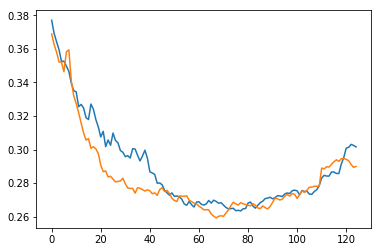

In [81]:
n = 25
m = 151
#plt.plot(adagrad_xgboost_test[n+1:m+1])
plt.plot(adagrad_xgboost_test[n+1:m+1])
plt.plot(evals_result['test']['AdaLoss'][n:m])

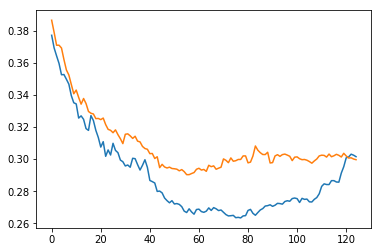

In [70]:
n = 25
m = 151
plt.plot(model.test_loss[n+1:m+1])
plt.plot(adagrad_test[n+1:m+1])